# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

Подключим следующие библиотеки:
- `pandas` для последующей работы с данными и таблицами;
- `sklearn` для работы с моделями, а именно:
    - `DecisionTreeClassifier` - модель решающего дерева;
    - `LogisticRegression` - модель логистической регрессии;
    - `RandomForestClassisfier` - модель случайного леса;
    - `DummyClassifier` - простейшая модель;
    - `train_test_split` - функция для разделения данных на тестовую и тренировочную выборки;
    - `accuracy_score` - функция, которая считает accuracy для модели;
- `matplotlib.pyplot` для построения графиков.

In [29]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Откроем `.csv` файл с предоставленными данными о поведении клиентов. Запишем таблицу в переменную `data`.

In [30]:
try:
    data = pd.read_csv('/datasets/users_behavior.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

Выведем первые 20 строк датасета.

In [31]:
data.head(20)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Также получим основную информацию о датасете при помощи метода `info()`.

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Получим общую статистическую информацию овыборке при помощи метода `describe()`.

In [33]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Построим гистограммы по имеющимся столбцам.

array([[<AxesSubplot:title={'center':'calls'}>,
        <AxesSubplot:title={'center':'minutes'}>],
       [<AxesSubplot:title={'center':'messages'}>,
        <AxesSubplot:title={'center':'mb_used'}>],
       [<AxesSubplot:title={'center':'is_ultra'}>, <AxesSubplot:>]],
      dtype=object)

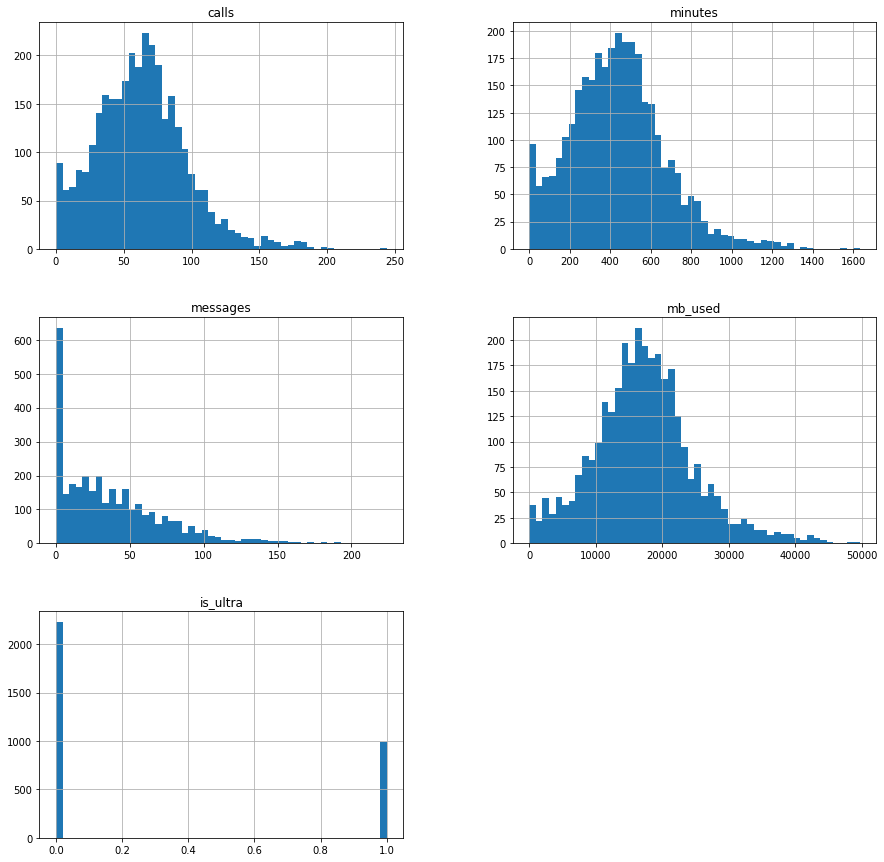

In [34]:
data.hist(figsize=(15, 15), bins=50)

Таким образом можем сказать, что в представленной выборке представлены данные о 3214 клиентах, в таблице не содержится пропусков, но при этом заметно, что присутствуют выбросы и распределение похоже на биномиальное.

## Разбейте данные на выборки

Разобьём данные на 3 выборки: обучающую, тестовую и валидационную.

Так как нам предоставлена изначально всего лишь одна выборка, то будем разбивать её на 3 части в следующем отношении:
* 60% изначальной выборки выделим в обучающую выборку;
* 20% изначальной выборки выделим в валидационную выборку;
* Оставшиеся 20% изначальной выборки выделим в тестовую выборку.

Для этого разделения дважды воспользуемся функцией `test_train_split` из библиотеки `sklearn`.

В самой выборке целевой признак содержится в колонке `is_ultra`. Запишем целевой признак в `target`, остальные признаки в `features`.

Будем использовать везде параметр `random_state=12345` для того, чтобы в будущем результаты эксперимента можно было повторить.

In [35]:
target = data['is_ultra']
features = data.drop(columns=['is_ultra'])

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

Проверим получившиеся выборки через `info()`.

In [36]:
features_train.info()
print()
features_valid.info()
print()
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 3027 to 482
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     1928 non-null   float64
 1   minutes   1928 non-null   float64
 2   messages  1928 non-null   float64
 3   mb_used   1928 non-null   float64
dtypes: float64(4)
memory usage: 75.3 KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643 entries, 1386 to 3197
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     643 non-null    float64
 1   minutes   643 non-null    float64
 2   messages  643 non-null    float64
 3   mb_used   643 non-null    float64
dtypes: float64(4)
memory usage: 25.1 KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643 entries, 160 to 2313
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     643 non-null    float64
 1   min

Таким образом мы получили 3 выборки:
* Обучающаю выборку на 1928 значений;
* Валидационную и тестовую выборки на 643 значения.

Перейдём к обучению моделей.

## Исследуйте модели

В данном случае нам предстоит решить задачу классификации: Подходит ли клиенту тариф "Ультра" или не подходит с вариантами ответа `1` или `0`. Соответственно для задачи классификации мы можем использовать три различных модели:
* Решающее дерево;
* Случайный лес;
* Логистическая регрессия.

### Решающее дерево

Начнём с решающего дерева.
Поступим следующим образом:
* Будем задавать гиперпараметр `max_depth` в цикле от 1 до 15 последовательно.
* На каждом проходе цикла будем проверять модель на валидационной выборке и если `accuracy` и, если модель показывает более высокую точность чем предыдущая, сохраним саму модель в переменной `best_model`, а параметр глубины в переменной `best_tree_depth`.

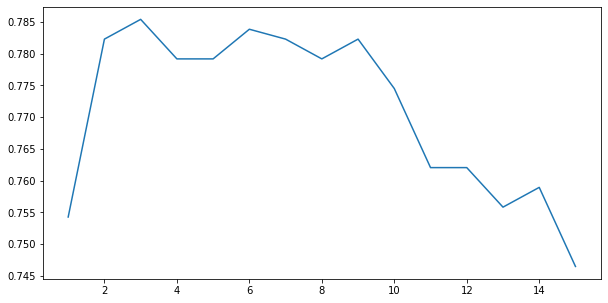

Наилучшая точность модели: 78.5% была достигнута при глубине решающего дерева 3


In [37]:
acc_tree = 0
acc_tree_best = 0
best_depth = 0
depth_list = [*range(1,16)]
acc_tree_list = []
for depth in range(1,16):
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model_tree.fit(features_train, target_train)
    predictions_tree = model_tree.predict(features_valid)
    acc_tree = accuracy_score(predictions_tree, target_valid)
    acc_tree_list.append(acc_tree)
    if acc_tree > acc_tree_best:
        model_tree_best = model_tree
        best_depth = depth
        acc_tree_best = acc_tree
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(depth_list, acc_tree_list)
plt.show()
print(f'Наилучшая точность модели: {acc_tree_best:.1%} была достигнута при глубине решающего дерева {best_depth}')

На проверках на валидационных выборках мы получили модель с наилучшим значением `accuracy` 78,5% при глубине решающего дерева равной 3. Как можно заметить после достижения глубины дерева равной 10 точность обученной модель начинает падать, соответственно происходит переобучение.

### Случайный лес

Теперь построимм модель на основе случайного леса. У случайноо леса также есть несколько гиперпараметров, которые можно изменять: `n_estimators` - количество решающих деревьев леса, `max_depth` - максимальная глубина решающего дерева. Поступим следующим образом:

* Создадим цикл, в котором будем изменять количество решающих деревьев от 10 до 200 с шагом в 10.
* Создадим вложенный цикл, в котором будем изменять максимальную глубину решающего дерева от 1 до 15 с шагом в 1.
* Во вложенном цикле будем создавать модель, тренировать и проверять на валидационной выборке. Если точность модели выше, чем максимальная достигнутая до этого точность, будем записывать модель, глубину решающего дерева и количество деревьев в специальные переменные.
* В конце выведем графики, на которых покажем точность моделей в зависимости от параметров.

Также будем испоьзовать гиперпараметр `random_state=12345` для воспроизводимости результатов.

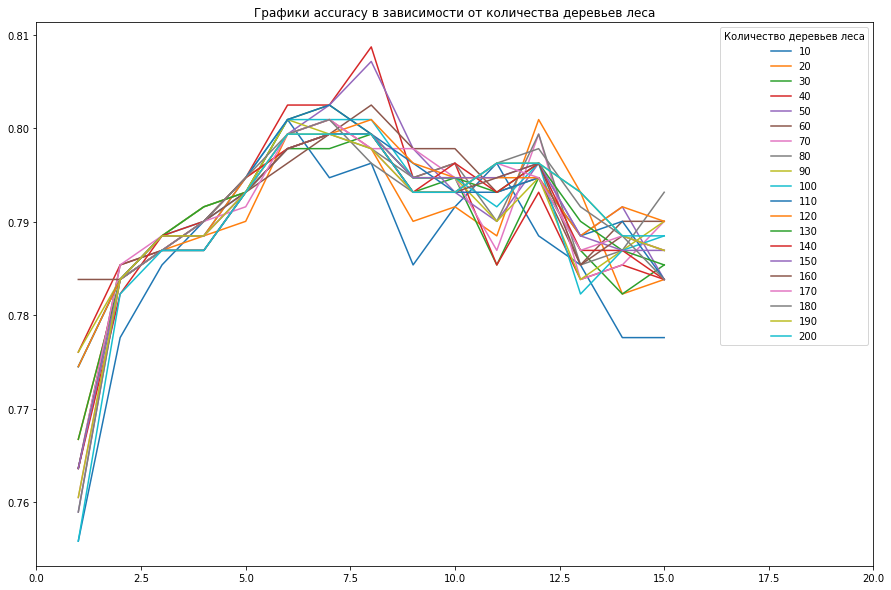

Наилучшая точность модели: 80.9% была достигнута при глубине решающего дерева 8 и количестве деревьев равном 40


In [38]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Графики accuracy в зависимости от количества деревьев леса')

acc_forest = 0
acc_forest_best = 0
best_depth_forest = 0
best_estimators = 0
estimators_list = [*range(10, 201, 10)]
depth_forest_list = [*range(1, 16)]
acc_forest_list = []
for estimators in range(10, 201, 10):
    acc_forest_list.append([])
    for depth in range(1, 16):
        model_forest = RandomForestClassifier(max_depth=depth, n_estimators=estimators, random_state=12345)
        model_forest.fit(features_train, target_train)
        acc_forest = model_forest.score(features_valid, target_valid)
        if acc_forest > acc_forest_best:
            acc_forest_best = acc_forest
            best_depth_forest = depth
            best_model_forest = model_forest
            best_estimators = estimators
        acc_forest_list[int(estimators / 10) - 1].append(acc_forest)
    ax.plot(depth_forest_list, acc_forest_list[int(estimators / 10) - 1], label = str(estimators))
ax.legend(title='Количество деревьев леса', loc=1)
ax.set_xlim(0, 20)
plt.show()
print(f'Наилучшая точность модели: {acc_forest_best:.1%} была достигнута при глубине решающего дерева {best_depth_forest} и количестве деревьев равном {best_estimators}')

На проверках на валидационных выборках мы получили модель с наилучшим значением `accuracy` 80,9% при глубине решающего дерева равной 8 и количестве деревьев равному 40. Как можно заметить после достижения глубины дерева равной 7 или 8 точность большинства моделей начинает снижаться и вероятно в этот момент происходит переобучение.

Следует заметить, что модель обучалась сильно дольше, чем модель случайного леса.

### Логистическая регрессия

Построим модель на основе логистической регрессии. У этой модели есть гиперпараметр `max_iter` - количество итераций обучения. Поступим с данной моделью следующим образом:

* В цикле переберём значения `max_iter` от 10 до 300 с шагом в 10;
* На каждом проходе цикла будем проверять модель на валидационной выборке и, если модель показывает более высокую точность чем наилучшая, сохраним модель и максимальное число итераций для этой модели;
* В конце выведем точности всех полученных моделей в виде графика.

Также будем использовать гиперпараметры `random_state=12345` для воспроизводимости эксперимента и `solver='lbfgs'` в качестве выбранного решателя.

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

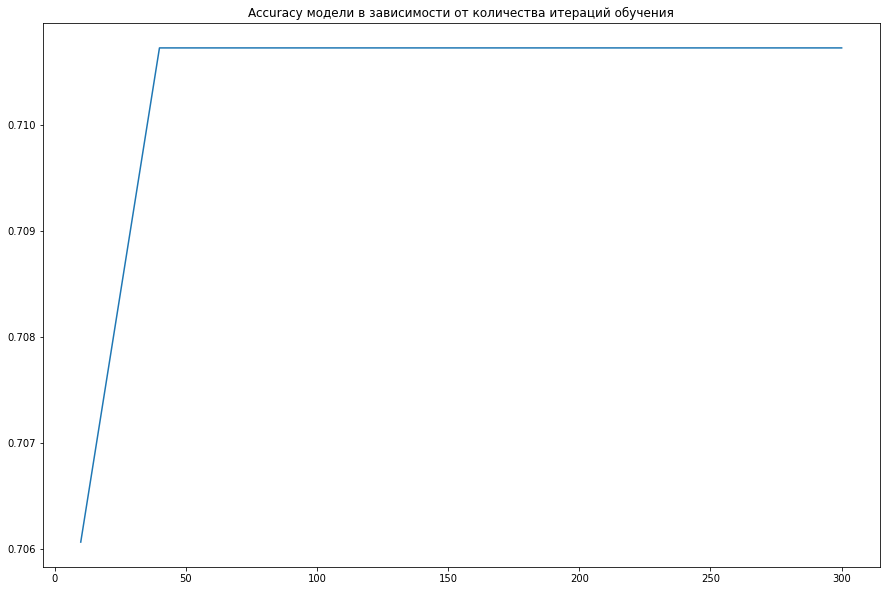

Наилучшая точность модели: 71.1% была достигнута при максимальном числе итераций 40


In [39]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Accuracy модели в зависимости от количества итераций обучения')

acc_regression = 0
acc_best_regression = 0
best_iter_regression = 0
iter_list = [*range(10, 301, 10)]
acc_regression_list = []
for max_it in range(10, 301, 10):
    model_regression = LogisticRegression(max_iter=max_it, solver='lbfgs', random_state=12345)
    model_regression.fit(features_train, target_train)
    acc_regression = model_regression.score(features_valid, target_valid)
    acc_regression_list.append(acc_regression)
    if acc_regression > acc_best_regression:
        best_model_regression = model_regression
        acc_best_regression = acc_regression
        best_iter_regression = max_it
ax.plot(iter_list, acc_regression_list)
plt.show()
print(f'Наилучшая точность модели: {acc_best_regression:.1%} была достигнута при максимальном числе итераций {best_iter_regression}')

Как можно заметить по графику и выводу ячейки количество итераций от 10 до 30 включительно не позволяет логистической регрессии сойтись. При хотя бы 40 итерациях модель сходится и достигает постоянной точности в 71,1% (на графике это выражается выходом на плато).

Перейдём теперь к проверке моделей на тестовой выборке.

## Проверьте модель на тестовой выборке

Лучший результат на валидационных выборках показала модель случайного леса, проверим её теперь на финальной тестовой выборке.

In [40]:
print(f'Accuracy для модели случайного леса на тестовой выборке: {best_model_forest.score(features_test, target_test):.1%}')

Accuracy для модели случайного леса на тестовой выборке: 79.6%


Получаем следующие результаты:
* Лучшая модель для случайного леса, на валидационной выборке показавшая `accuracy` 80,9%, показала на тестовой выборке `accuracy` 79,6% и также преодолела критерий в 75%. Таким образом данная модель показала результат ~80% `accuracy` как на валидационной, так и на тестовой выборках. Соответственно из исследуемых моделей следует выбрать именно модель случайного леса с максимальной глубиной решающего дерева равной 8 и количеством деревьев равному 40.

## (бонус) Проверьте модели на адекватность

Также проведём проверку моделей на адекватность. Сделаем это использовав `DummyClassifier` - простейшую модель, которая будет предсказывать тот параметр, который встречается чаще. Если её `accuracy` окажется ниже `accuracy` модели, тогда будем считать модель адекватной.

In [41]:
model_dummy = DummyClassifier(random_state=12345)
model_dummy.fit(features_train, target_train)
print(f'`accuracy` простейшей модели: {model_dummy.score(features_valid, target_valid):.1%}')

`accuracy` простейшей модели: 70.6%


Соответственно модели случайного леса и решающего дерева можно считать адекватными, в то время как модель логистической регрессии считать адекватной нельзя - её результат практически совпадает с уровнем, который показывает простейшая модель классификации.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
